In [1]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

In [3]:
insurance_data = pd.read_csv(r'https://raw.githubusercontent.com/puneettrainer/datasets/main/insurance_fraud.csv')

### Brief comparison of `Gini score` and `Entropy`

`Gini` and `Entropy` are impurity scores which are used to evaluate the best way to split data in a classifier decision tree. Both these metrics have their own merits and demerits.

### `Gini index`

| Advantages | Disadvantages |
| --- | --- |
| computationally efficient | may not be very effective in case of imbalanced data |
| immune to outliers |  |
| easier to understand |  |

Since `gini index` operates on splitting data based on impurity, if data is imbalanced, it may not be very optimal.


### `Entropy`

| Advantages | Disadvantages |
| --- | --- |
| more suited for multi-class problems | computationally resource-intensive |
| splits are more balanced as its more sensitive to the probabilities |  |

`Information Gain` is a measure of reduction in entropy between the parent node and the child nodes. The higher this value is, the better the reduction in impurity is. 


### Hyperparameter tuning in Decision Trees

Decision Tree algorithms are very easy to interpret classifiers or regressors, in that they are able to clearly convey how they arrive at a particular prediction. However, they also require to be configured appropriately to be used to their maximum optimality. For this purpose, we configure `hyperparameters` of decision tree algorithms.

In machine learning algorithms, `parameters` are considered to be the input features and the targets, their associated `weights`, etc. that are directly used within the algorithm. `Hyperparameters` are simply configurations of the model, which are independent of the data the alogrithm is modeled around. These are values which optimise a machine learning model.

In case of `DecisionTreeClassifier`, most commonly adjusted hyperparameters are:
- `max_depth`: an integer value which controls the maximum depth of the tree.
- `min_sample_split`: numeric value which controls whether a node is split further or not
- `max_features`: controls the number of features to consider at each split
- `class_weight`: allows control over classes which have lesser number of samples and might be prone to be overlooked by the algorithm
- `ccp_alpha`: controls the complexity of the decision tree by pruning it.

### Impact of configuring `max_depth`

In decision tree algorithms, as the dataset is split further and further till a point that each node represents a single class (ideally), the decision tree tends to generate layers between the `root` node and the `leaf` nodes.

The more depths there are to the decision tree, the greater amount of `noise` or extreme narrow logic is developed to arrive at a class. While this will work on the training data, this complicates structure would fail to be work as correctly for real-world, unseen data.

Depths also end up making the model more computationally resource-intensive.

In order to control the `narrowness` of the patterns identified by the algorithm, we can control the number of `depths` that are constructed by the algorthm.

By doing so, we intentionally introduce some form of incorrectness to the algorithm because the patterns identified cover a broader set of samples than the narrow set of samples deduced by the unconfigured algorithm. At the same time, we also ensure that the model trained is generalized and applicable to more than just the training data.

In [3]:
target_field = 'FRAUD'
input_fields = ['ACCOUNT_AGE', 'CUSTOMER_AGE', 'LIABILITY_AMOUNT', 'DEDUCTABLE', 'ANNUAL_FEE',
                'UMBRELLA_LIMIT', 'GENDER', 'EDUCATION_LEVEL', 'OCCUPATION', 'CAPITAL_GAINS', 'INCIDENT_TYPE', 'INCIDENT_SEVERITY',
                'AUTHORITIES', 'NUMBER_OF_VEHICLES', 'TOTAL_CLAIM_AMOUNT']

In [4]:
categorical_fields = list(insurance_data[input_fields].select_dtypes(exclude='number').columns)

In [5]:
training_data, test_data = train_test_split(insurance_data
                                           ,test_size=0.3
                                           ,random_state=10)

In [6]:
encoder = OneHotEncoder().fit(insurance_data[categorical_fields])
training_data.loc[:, encoder.get_feature_names_out()] = encoder.transform(training_data[categorical_fields]).toarray()
test_data.loc[:, encoder.get_feature_names_out()] = encoder.transform(test_data[categorical_fields]).toarray()

In [7]:
input_fields = list(insurance_data[input_fields].select_dtypes(include='number')) + list(encoder.get_feature_names_out())

In [8]:
performance = {}

for depth in range(1, 10):
    model = DecisionTreeClassifier(max_depth=depth)
    model.fit(training_data[input_fields], training_data[target_field])
    predictions = model.predict(test_data[input_fields])

    performance.update({depth:f1_score(test_data[target_field], predictions, pos_label='Y')})

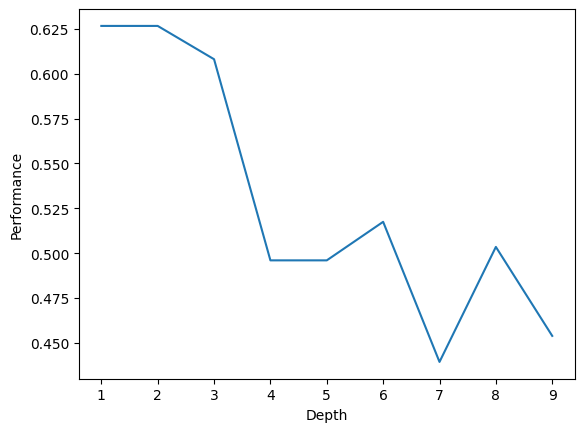

In [9]:
plt.plot(performance.keys(), performance.values())
plt.xlabel('Depth')
plt.ylabel('Performance')
plt.show()

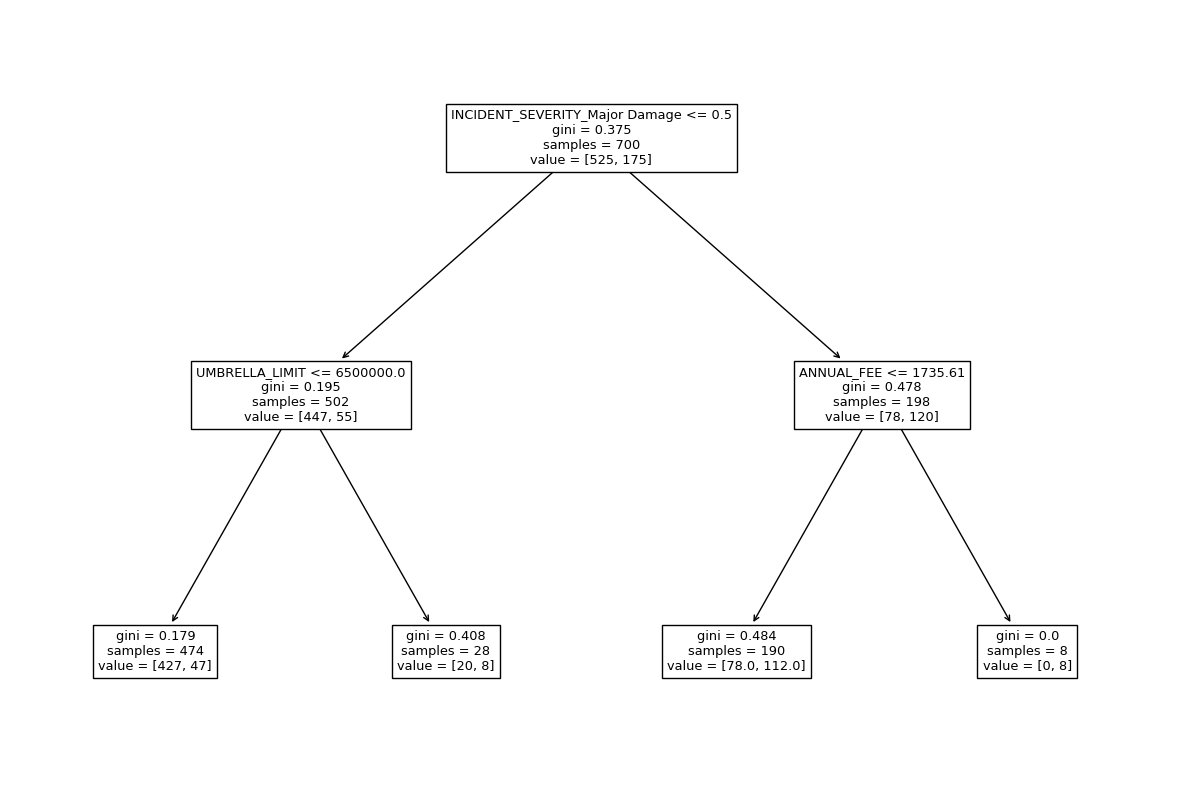

In [10]:
model = DecisionTreeClassifier(max_depth=2)
model.fit(training_data[input_fields], training_data[target_field])
plt.figure(figsize=(15, 10))
plot_tree(model, feature_names=input_fields)
plt.show()

### Impact of `min_samples_split`

The `min_samples_split` hyperparameter specifies the minimum number of samples that should be at a node. If splitting a node would result in a lesser number of samples than this value, the node is not split further and is considered as a leaf node.

Controlling whether or not to split a node further allows us to prevent the model from creating further narrow splits in the data, which may not be applicable to real-world data. Conversely, an unoptimal value can cause the algorithm to not identify important criteria which may result in correct classification.

In [11]:
performance = {}

for min_samples in range(200, 550):
    model = DecisionTreeClassifier(min_samples_split=min_samples)
    model.fit(training_data[input_fields], training_data[target_field])
    predictions = model.predict(test_data[input_fields])

    performance.update({min_samples:f1_score(test_data[target_field], predictions, pos_label='Y')})

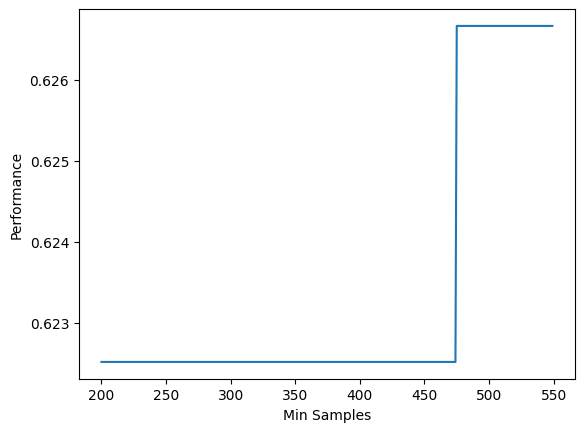

In [12]:
plt.plot(performance.keys(), performance.values())
plt.xlabel('Min Samples')
plt.ylabel('Performance')
plt.show()

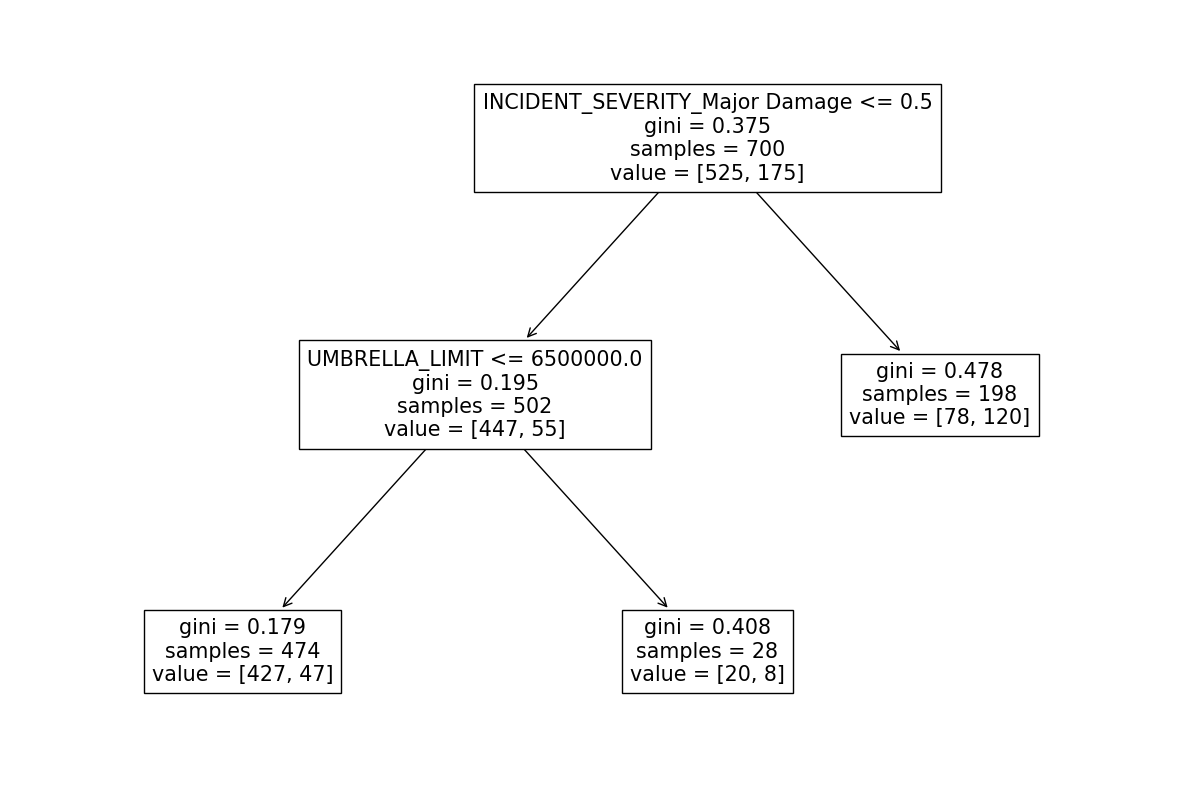

In [13]:
model = DecisionTreeClassifier(min_samples_split=475)
model.fit(training_data[input_fields], training_data[target_field])
plt.figure(figsize=(15, 10))
plot_tree(model, feature_names=input_fields)
plt.show()

### Impact of `max_features`

The `max_features` hyperparameter controls the number of features that are considered and evaluated for splitting a node. When specified, the algorithm will randomly choose `max_features` number of input features (out of the total number of input features that we have specified) and split into further nodes, by evaluating the impurity score as usual.

In [14]:
model = DecisionTreeClassifier(max_features=40)
model.fit(training_data[input_fields], training_data[target_field])
predictions = model.predict(test_data[input_fields])
f1_score(test_data[target_field], predictions, pos_label='Y')

0.43243243243243246

### Impact of `class_weight`

In most real-world classification problems, the distribution of classes is not uniform. For example, a bank may have data on all the potential-customers they have contacted. But out of all the potential customers that they reach out to, not every one (or a high portion of them) actually convert into a customer.

So, if we were creating a model to figure how `marketable` or `in-demand` a product is (therefore, assessing whether it would be a profitable venture), the data we train out classifier on will have a lot of observations which are `true negatives` as opposed to observations which are `true positives`. This type of dataset is called an imbalanced dataset. In such cases, we may configure the weights of the classes in order to compensate for the imbalance - resulting in a fair, `balanced` classifier.

In [15]:
model = DecisionTreeClassifier(class_weight={'Y':700, 'N':7})
model.fit(training_data[input_fields], training_data[target_field])
predictions = model.predict(test_data[input_fields])
f1_score(test_data[target_field], predictions, pos_label='Y')

0.4142857142857143

### `Pruning`

Pruning is a technique through which we control overfitting in a decision tree, by removing irrelavant nodes.

One of the most important methods of pruning a decision tree is `Cost Complexity Pruning` or `Weakest Link Pruning`.

This methods evaluates the performance of the tree by summing the individual `impurity score` (in case of classification trees)/`sum of squared residual` (in case of regression trees) of each leaf node, and adding a `regularized penalty` times the number of leaf nodes to this sum. This generates a new metric, called the `tree score`.

$\text{Tree Score} = \sum{\text{score of each leaf}} + \alpha \times \text{no. of leaf nodes}$

Here,<br>
$\alpha \implies \text{complexity parameter}$

We can start off by using the `cost_complexity_pruning_path()` method of the `DecisionTreeRegressor` class, to get a set of optimal values of $\alpha$. This method iteratively prunes a fully contructed tree (by removing nodes from the end all the way up to the root node), and calculates the $\alpha$ values along with impurity values on its own.

$\alpha = \frac{\text{impurity of current sub-tree} - \text{impurity of after removing sub-tree}}{\text{no. of leaf nodes before pruning} - \text{no. of leaf nodes after pruning}}$

$\alpha$ computed by `cost_complexity_pruning_path()` may be positive or negative:
- $+\alpha \implies$ balanced decrease in number of nodes and impurity
- $-\alpha \implies$ huge reduction in number of nodes and but increase in impurity

For the purpose of cross validation, the `ccp_alpha` value cannot be a negative number, so we filter out negative $\alpha$ values computed by `cost_complexity_pruning_path()`.

In [16]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import root_mean_squared_error

In [17]:
student_data = pd.read_csv(r"E:\data\student_performance.csv")

In [18]:
target_field = 'Performance Index'
input_fields = list(student_data.columns)
input_fields.remove(target_field)

In [19]:
# directly formatting Extracurricular Activities into 0, 1
student_data['Extracurricular Activities'] = student_data['Extracurricular Activities'].map({'Yes':1, 'No':0})

In [20]:
training_data, test_data = train_test_split(student_data
                                           ,test_size=0.25
                                           ,random_state=15)

In [21]:
model = DecisionTreeRegressor().fit(training_data[input_fields], training_data[target_field])
predictions = model.predict(test_data[input_fields])

In [23]:
tree_score_metrics = pd.DataFrame(model.cost_complexity_pruning_path(training_data[input_fields], training_data[target_field]))
tree_score_metrics

,ccp_alphas,impurities
0,0.000000e+00,0.232311
1,-6.071532e-17,0.232311
2,-6.071532e-17,0.232311
3,-6.066111e-17,0.232311
4,-6.066111e-17,0.232311
...,...,...
4621,9.759751e+00,66.999010
4622,1.025236e+01,77.251371
4623,2.753834e+01,104.789709
4624,2.849517e+01,133.284878


In [24]:
reg_values = tree_score_metrics.loc[tree_score_metrics['ccp_alphas'] >= 0, 'ccp_alphas']
training_score = {}
test_score = {}

for alpha in reg_values:
    model = DecisionTreeRegressor(random_state=13, ccp_alpha=alpha).fit(training_data[input_fields]
                                                                       ,training_data[target_field])

    training_score.update({alpha:root_mean_squared_error(training_data[target_field]
                                                        ,model.predict(training_data[input_fields])
                                                        )
                          })
    test_score.update({alpha:root_mean_squared_error(test_data[target_field]
                                                    ,model.predict(test_data[input_fields])
                                                     )
                      })

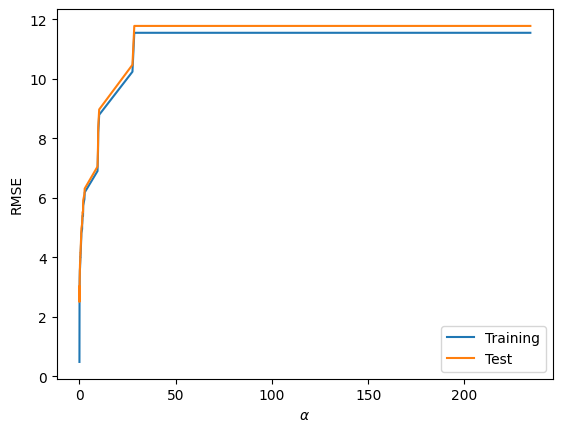

In [25]:
plt.plot(training_score.keys(), training_score.values(), label='Training')
plt.plot(test_score.keys(), test_score.values(), label='Test')
plt.ylabel('RMSE')
plt.xlabel(r'$\alpha$')
plt.legend()
plt.show()

### Using `Cross Validation` for algorithm tuning

`Cross validation` is a technique which allows us to evaluate the performance of an algorithm by testing it on multiple samples of the same dataset. This way, our model evaluation is not based on just a random, one-off chance selection of observations - rather it is tested across the entire avaliable dataset. This is basically ensuring a stricter evaluation of the model performance.

In `sklearn`, we can simply use the `cross_val_score` function to perform cross validation.
```
from sklearn.model_selection import cross_val_score
cross_val_score(model, training_data[input_fields], training_data[target_field], cv=n)
```
In this function, `cv` is an integer value which specifies the number of samples that will be created and evaluated.

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

rmse = make_scorer(mean_squared_error, squared=False)
model = DecisionTreeRegressor(ccp_alpha=0.2)

cross_val_score(model
               ,training_data[input_fields]
               ,training_data[target_field]
               ,cv=7
               ,scoring=rmse)

array([3.61277187, 3.71304968, 3.61349399, 3.60831811, 3.51369592,
       3.58066223, 3.62634721])